#  Interactions at baits

In this Jupyter notebook, the classes ``BaitedDigest`` and ``BaitedDigestSet`` are demonstrated.

The class ``BaitedDigest`` can be used to group interactions according to the baits in which they end. Within this class, interactions are further differntiated according to interaction category (``DI``, ``UIR``, ``UI`` and ``ALL``) and the enrichment status of the two digests (``NE`` and ``EN``). Interactions with the enrichment state `NN` or ``EE`` cannot be assigned unabgiuously to a baited digests and, therefore, are not taken into account. However, for capture Hi-C data, such interactions make up only a small percentage (around 10% on average).

The class ``BaitedDigestSet`` can be used to manage a number of ``BaitedDigest`` objects. At its core, it is a dictionary in which ``BaitedDigest`` objects are stored, with the coordinates of the digests serving as keys.

This structuring of the data enables properties of interactions that end in the same baited digest to be investigated and compared for the different interaction categories and enrichment states.

## Setting up the notebook

In [9]:
import sys
import os
import pandas
sys.path.append("..")
from diachr import DiachromaticInteractionSet
from diachr import BaitedDigest
from diachr import BaitedDigestSet

## Test file

We have prepared a small test file in ``Diachromatic11`` format (already contains the  interaction categories ``DI``, ``UIR`` and ``UI``) that only contains interactions on chromosome ``chr21`` and ``chr22``.

In [10]:
# Interactions on 'chr21' and 'chr22' only
#INTERACTION_FILE = "../tests/data/baited_digests_d11_interaction_test_file.tsv.gz"

# 100,000 randomly selected interactions
#INTERACTION_FILE = "../tests/data/baited_digests_d11_interaction_test_file_2.tsv.gz"

# Real data
INTERACTION_FILE = "../stair_like_structure_minimal/JAV_MAC_M1_RALT_20000_evaluated_and_categorized_interactions.tsv.gz"

## Creation of a ``BaitedDigestSet``

First, we create a ``DiachromaticInteractionSet`` from the test file.

In [11]:
d11_interaction_set = DiachromaticInteractionSet()
d11_interaction_set.parse_file(i_file=INTERACTION_FILE, verbose=True)

[INFO] Parsing Diachromatic interaction file ...
	[INFO] ../stair_like_structure_minimal/JAV_MAC_M1_RALT_20000_evaluated_and_categorized_interactions.tsv.gz
	[INFO] Parsed 1,000,000 interaction lines ...
	[INFO] Parsed 2,000,000 interaction lines ...
	[INFO] Parsed 3,000,000 interaction lines ...
	[INFO] Parsed 4,000,000 interaction lines ...
	[INFO] Set size: 4,581,057
[INFO] ... done.


Next, we create a ``BaitedDigestSet`` and pass the ``DiachromaticInteractionSet``.

In [12]:
baited_digest_set = BaitedDigestSet()
read_interactions_info_dict = baited_digest_set.ingest_interaction_set(d11_interaction_set, verbose=True)

[INFO] Reading interactions and group them according to chromosomes and baited digests ...
	[INFO] Read 1,000,000 interactions ...
	[INFO] Read 2,000,000 interactions ...
	[INFO] Read 3,000,000 interactions ...
	[INFO] Read 4,000,000 interactions ...
	[INFO] Total number of interactions read: 4,581,057
	[INFO] Total number of baited digests: 21,681
[INFO] ... done.


The function ``get_ingest_interaction_set_info_report()`` returns a string with more detailed information on the ingestion.

In [13]:
print(baited_digest_set.get_ingest_interaction_set_info_report())

[INFO] Report on ingestion of interactions:
	[INFO] Total number of interactions read: 4,581,057
	[INFO] Discarded NN and EE interactions: 379,907
	[INFO] Total number of ingested NE and EN interactions: 4,201,150
	[INFO] Broken down by interaction category and enrichment status: 
		[INFO] DI: 
			[INFO] NE: 90,700
			[INFO] EN: 93,315
		[INFO] UIR: 
			[INFO] NE: 90,634
			[INFO] EN: 93,256
		[INFO] UI: 
			[INFO] NE: 1,920,279
			[INFO] EN: 1,912,966
		[INFO] ALL: 
			[INFO] NE: 2,101,613
			[INFO] EN: 2,099,537
	[INFO] Total number of baited digests: 21,681
[INFO] End of report.



And the function ``get_ingest_interaction_set_table_row()`` returns the same information in table format.

In [14]:
print(baited_digest_set.get_ingest_interaction_set_table_row())

:TR_INGESTION:	TOTAL_INTERACTIONS_READ	DISCARDED	INGESTED	DI_NE	DI_EN	UIR_NE	UIR_EN	UI_NE	UI_EN	ALL_NE	ALL_EN	BAITED_DIGESTS
:TR_INGESTION:	4581057	379907	4201150	90700	93315	90634	93256	1920279	1912966	2101613	2099537	21681



### Explanation of the data structure

In the object ``baited_digest_set``, the chromosomes are first grouped according to chromosomes. For example, ``baited_digest_set._baited_digest_dict['chr21']`` all ``BaitedDigest`` object that were created for ``chr21``.

In [15]:
dict_all_baited_digest_objects_on_chr21 = baited_digest_set._baited_digest_dict['chr21']

A individual ``BaitedDigest`` object can be aaccessed via its digest coordinates.

In [16]:
individual_baited_digest_object_on_chr21 = baited_digest_set._baited_digest_dict['chr21']['chr21\t33167499\t33175012']

An ``BaitedDigest``, contains all interactions that end in this digest, spearted by interaction category and enrichment status. Here, as an example, an interaction of category ``DI`` with enricchment state ``NE``.

In [17]:
baited_digest_set._baited_digest_dict['chr21']['chr21\t33167499\t33175012'].interactions['DI']['NE'][0].get_category()

'DI'

In [18]:
baited_digest_set._baited_digest_dict['chr21']['chr21\t33167499\t33175012'].interactions['DI']['NE'][0].enrichment_status_tag_pair

'NE'

## Pairwise differences of interaction distances at baits

First, we used our data structure for the analysis with the paairwise differences of interacction distances at baits. The function ``get_pairwise_interaction_distances_at_baits()`` combines the pairwise differences from all baits and returns a dictionary with all differences separated by interaction category and enrichment status.

In [11]:
import sys
import os
import pandas
sys.path.append("..")
from diachr import DiachromaticInteractionSet
from diachr import BaitedDigest
from diachr import BaitedDigestSet
INTERACTION_FILE = "../tests/data/baited_digests_d11_interaction_test_file.tsv.gz"
#INTERACTION_FILE = "../stair_like_structure_minimal/JAV_MAC_M1_RALT_20000_evaluated_and_categorized_interactions.tsv.gz"
d11_interaction_set = DiachromaticInteractionSet()
d11_interaction_set.parse_file(i_file=INTERACTION_FILE, verbose=True)
baited_digest_set = BaitedDigestSet()
read_interactions_info_dict = baited_digest_set.ingest_interaction_set(d11_interaction_set, verbose=True)

[INFO] Parsing Diachromatic interaction file ...
	[INFO] ../tests/data/baited_digests_d11_interaction_test_file.tsv.gz
	[INFO] Set size: 118,468
[INFO] ... done.
[INFO] Reading interactions and group them according to chromosomes and baited digests ...
	[INFO] Total number of interactions read: 118,468
	[INFO] Total number of baited digests: 680
[INFO] ... done.


In [12]:
pid = baited_digest_set.get_pairwise_differences_of_interaction_distances_at_baits(
    chromosomes=['chr21', 'chr22'],
    #chromosomes=None,
    verbose=True
)

[INFO] Getting all pairwise differences of interaction distances at baits ...
	[INFO] Processing chromosome chr21 ...
	[INFO] Processing chromosome chr22 ...
[INFO] ... done.


The dictionary can be passed to the function ``get_pairwise_interaction_distances_at_baits_histograms()``, which creates the histograms.

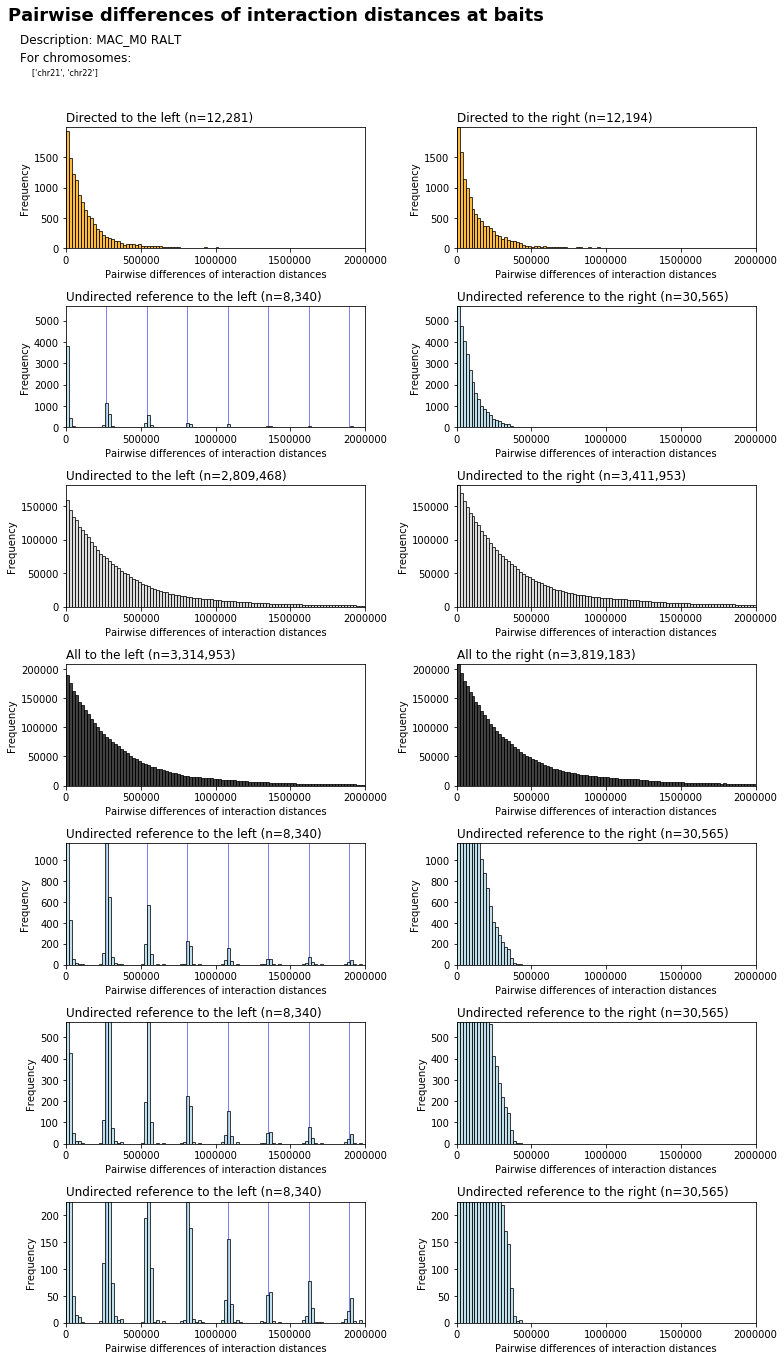

In [13]:
fig = baited_digest_set.get_pairwise_differences_of_interaction_distances_at_baits_histograms(
    pid_dict = pid,
    description = "MAC_M0 RALT",
    pdf_file_name = 'MAC_M0_RALT_pid_historgrams.pdf'
)

## Number pairs at baits ``(NE, EN)``

In [40]:
import sys
import os
import pandas
sys.path.append("..")
from diachr import DiachromaticInteractionSet
from diachr import BaitedDigest
from diachr import BaitedDigestSet
INTERACTION_FILE = "../tests/data/baited_digests_d11_interaction_test_file.tsv.gz"
INTERACTION_FILE = "../stair_like_structure_minimal/JAV_MAC_M1_RALT_20000_evaluated_and_categorized_interactions.tsv.gz"
d11_interaction_set = DiachromaticInteractionSet()
d11_interaction_set.parse_file(i_file=INTERACTION_FILE, verbose=True)
baited_digest_set = BaitedDigestSet()
read_interactions_info_dict = baited_digest_set.ingest_interaction_set(d11_interaction_set, verbose=True)

[INFO] Parsing Diachromatic interaction file ...
	[INFO] ../stair_like_structure_minimal/JAV_MAC_M1_RALT_20000_evaluated_and_categorized_interactions.tsv.gz
	[INFO] Parsed 1,000,000 interaction lines ...
	[INFO] Parsed 2,000,000 interaction lines ...
	[INFO] Parsed 3,000,000 interaction lines ...
	[INFO] Parsed 4,000,000 interaction lines ...
	[INFO] Set size: 4,581,057
[INFO] ... done.
[INFO] Reading interactions and group them according to chromosomes and baited digests ...
	[INFO] Read 1,000,000 interactions ...
	[INFO] Read 2,000,000 interactions ...
	[INFO] Read 3,000,000 interactions ...
	[INFO] Read 4,000,000 interactions ...
	[INFO] Total number of interactions read: 4,581,057
	[INFO] Total number of baited digests: 21,681
[INFO] ... done.


### Interaction number pairs

In [41]:
i_num_pair_dict = baited_digest_set.get_number_pairs_at_baits(
    number_pair_type='I_NUM',
    #chromosomes=['chr21'],
    verbose=True
)

[INFO] Determining pairs of interaction numbers (to the left and right) at baits ...
	[INFO] Processing chromosome chr11 ...
	[INFO] Processing chromosome chr15 ...
	[INFO] Processing chromosome chr6 ...
	[INFO] Processing chromosome chr5 ...
	[INFO] Processing chromosome chr13 ...
	[INFO] Processing chromosome chr2 ...
	[INFO] Processing chromosome chr8 ...
	[INFO] Processing chromosome chrX ...
	[INFO] Processing chromosome chr22 ...
	[INFO] Processing chromosome chr7 ...
	[INFO] Processing chromosome chr10 ...
	[INFO] Processing chromosome chr1 ...
	[INFO] Processing chromosome chr18 ...
	[INFO] Processing chromosome chr19 ...
	[INFO] Processing chromosome chr17 ...
	[INFO] Processing chromosome chr21 ...
	[INFO] Processing chromosome chr4 ...
	[INFO] Processing chromosome chr12 ...
	[INFO] Processing chromosome chr9 ...
	[INFO] Processing chromosome chr14 ...
	[INFO] Processing chromosome chr3 ...
	[INFO] Processing chromosome chr20 ...
	[INFO] Processing chromosome chr16 ...
	[INF

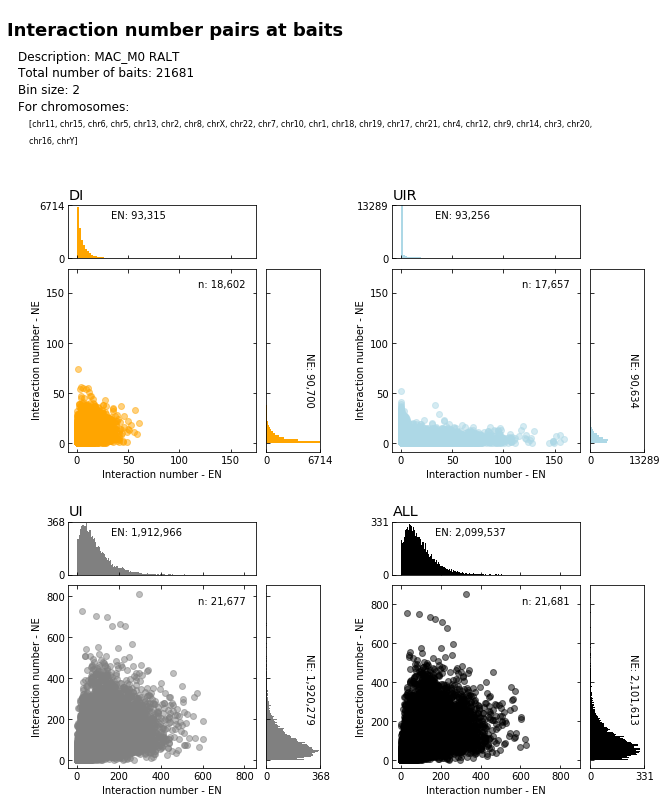

In [43]:
fig = baited_digest_set.get_pair_scatter_plots_with_histograms(
    pairs_dict = i_num_pair_dict,
    #set_xy_max = 50,
    sup_title = 'Interaction number pairs at baits',
    description = 'MAC_M0 RALT',
    pdf_file_name ='MAC_M0_RALT_i_num_pairs_scatter_plots_with_histograms.pdf')

### Read pair number pairs

In [44]:
rp_num_pairs_dict = baited_digest_set.get_number_pairs_at_baits(
    number_pair_type='RP_NUM',
    #chromosomes=['chr22']
    verbose = True
)

[INFO] Determining pairs of read pair numbers (to the left and right) at baits ...
	[INFO] Processing chromosome chr11 ...
	[INFO] Processing chromosome chr15 ...
	[INFO] Processing chromosome chr6 ...
	[INFO] Processing chromosome chr5 ...
	[INFO] Processing chromosome chr13 ...
	[INFO] Processing chromosome chr2 ...
	[INFO] Processing chromosome chr8 ...
	[INFO] Processing chromosome chrX ...
	[INFO] Processing chromosome chr22 ...
	[INFO] Processing chromosome chr7 ...
	[INFO] Processing chromosome chr10 ...
	[INFO] Processing chromosome chr1 ...
	[INFO] Processing chromosome chr18 ...
	[INFO] Processing chromosome chr19 ...
	[INFO] Processing chromosome chr17 ...
	[INFO] Processing chromosome chr21 ...
	[INFO] Processing chromosome chr4 ...
	[INFO] Processing chromosome chr12 ...
	[INFO] Processing chromosome chr9 ...
	[INFO] Processing chromosome chr14 ...
	[INFO] Processing chromosome chr3 ...
	[INFO] Processing chromosome chr20 ...
	[INFO] Processing chromosome chr16 ...
	[INFO]

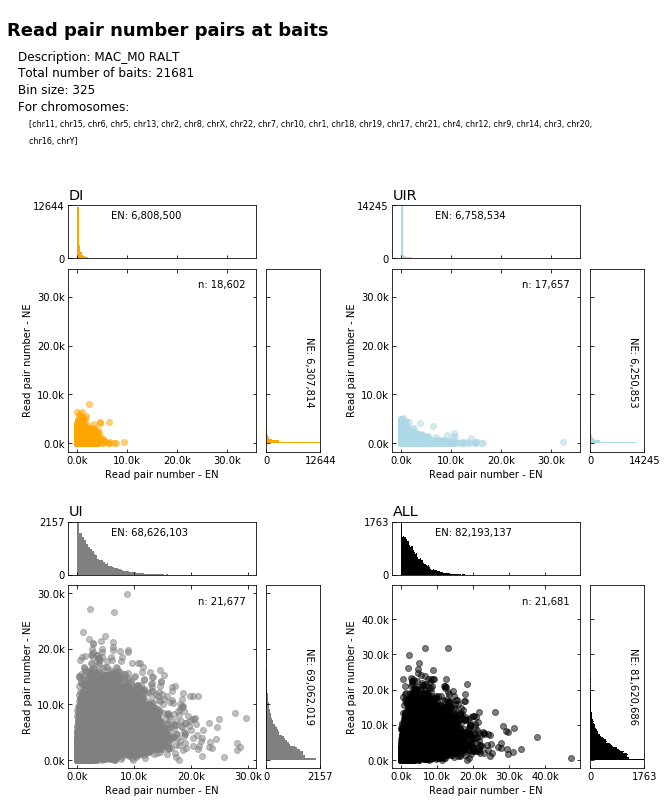

In [45]:
fig = baited_digest_set.get_pair_scatter_plots_with_histograms(
    pairs_dict = rp_num_pairs_dict,
    #set_xy_max = 1000,
    sup_title = 'Read pair number pairs at baits',
    description = 'MAC_M0 RALT',
    pdf_file_name ='MAC_M0_RALT_rp_num_pairs_scatter_plots_with_histograms.pdf')

### Median distance pairs

In [47]:
med_i_dist_pair_dict = baited_digest_set.get_number_pairs_at_baits(
    number_pair_type='MED_I_DIST',
    #chromosomes=['chr22'],
    verbose = True
)

[INFO] Determining pairs of median interaction distances (to the left and right) at baits ...
	[INFO] Processing chromosome chr11 ...
	[INFO] Processing chromosome chr15 ...
	[INFO] Processing chromosome chr6 ...
	[INFO] Processing chromosome chr5 ...
	[INFO] Processing chromosome chr13 ...
	[INFO] Processing chromosome chr2 ...
	[INFO] Processing chromosome chr8 ...
	[INFO] Processing chromosome chrX ...
	[INFO] Processing chromosome chr22 ...
	[INFO] Processing chromosome chr7 ...
	[INFO] Processing chromosome chr10 ...
	[INFO] Processing chromosome chr1 ...
	[INFO] Processing chromosome chr18 ...
	[INFO] Processing chromosome chr19 ...
	[INFO] Processing chromosome chr17 ...
	[INFO] Processing chromosome chr21 ...
	[INFO] Processing chromosome chr4 ...
	[INFO] Processing chromosome chr12 ...
	[INFO] Processing chromosome chr9 ...
	[INFO] Processing chromosome chr14 ...
	[INFO] Processing chromosome chr3 ...
	[INFO] Processing chromosome chr20 ...
	[INFO] Processing chromosome chr16 

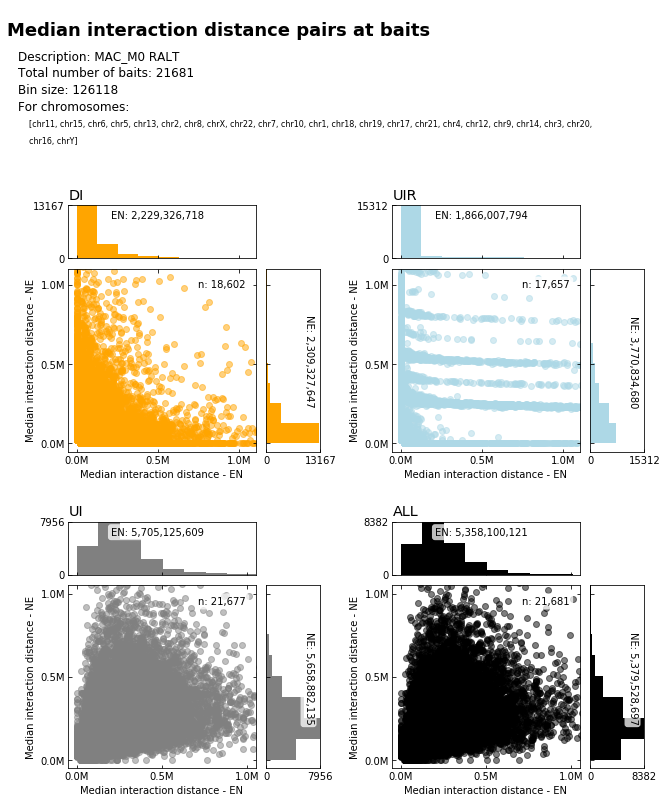

In [49]:
fig = baited_digest_set.get_pair_scatter_plots_with_histograms(
    pairs_dict = med_i_dist_pair_dict,
    set_xy_max = 1000000,
    sup_title = 'Median interaction distance pairs at baits',
    description = 'MAC_M0 RALT',
    pdf_file_name ='MAC_M0_RALT_med_i_dist_pairs_scatter_plots_with_histograms.pdf')

### Curb number pairs

In [ ]:
c_num_pairs_dict = baited_digest_set.get_number_pairs_at_baits(
    number_pair_type='C_NUM',
    #chromosomes=['chr22']
    verbose = True
)

[INFO] Determining pairs of curb numbers (to the left and right) at baits ...
	[INFO] Processing chromosome chr11 ...
	[INFO] Processing chromosome chr15 ...
	[INFO] Processing chromosome chr6 ...
	[INFO] Processing chromosome chr5 ...
	[INFO] Processing chromosome chr13 ...
	[INFO] Processing chromosome chr2 ...
	[INFO] Processing chromosome chr8 ...
	[INFO] Processing chromosome chrX ...
	[INFO] Processing chromosome chr22 ...
	[INFO] Processing chromosome chr7 ...
	[INFO] Processing chromosome chr10 ...
	[INFO] Processing chromosome chr1 ...
	[INFO] Processing chromosome chr18 ...
	[INFO] Processing chromosome chr19 ...
	[INFO] Processing chromosome chr17 ...
	[INFO] Processing chromosome chr21 ...
	[INFO] Processing chromosome chr4 ...
	[INFO] Processing chromosome chr12 ...
	[INFO] Processing chromosome chr9 ...
	[INFO] Processing chromosome chr14 ...
	[INFO] Processing chromosome chr3 ...


In [ ]:
fig = baited_digest_set.get_pair_scatter_plots_with_histograms(
    pairs_dict = c_num_pairs_dict,
    #xy_max = 50,
    sup_title = 'Curb number pairs at baits',
    description = 'MAC_M0 RALT',
    pdf_file_name ='MAC_M0_RALT_c_num_pairs_scatter_plots_with_histograms.pdf')

## Proportion of directed interactions on individual chromosomes

In [ ]:
baited_digest_set.proportion_of_directed_interactions_on_individual_chromosomes()

## BaitedDigest key sorted by starting position

In [ ]:
sorted_baited_digest_keys = baited_digest_set.get_baited_digest_keys_sorted_by_sta_pos()
for i in sorted_baited_digest_keys['chr21']:
    print(i)